# TinyStories Language Model Experiments

This notebook compares two different approaches for language modeling on the TinyStories dataset:
1. A Deep Reservoir Computing-based Model
2. A Transformer-based Model

Both models will be evaluated on the same dataset with the same evaluation metrics for fair comparison.

In [1]:
import os
import torch

# -----------------------------------------------------------------------------
# Shared Configuration for Both Models
# -----------------------------------------------------------------------------

SHARED_CONFIG = {
    # Data parameters
    'MAX_STORIES': 2000,                # Number of stories to use for training
    
    # Training parameters
    'EPOCHS': 4,                       # Number of training epochs
    'BATCH_SIZE': 32,                  # Batch size for training
    'BLOCK_SIZE': 128,                 # Context size for training
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Evaluation parameters
    'EVAL_INTERVAL': 1000,              # Steps between evaluations
    'EVAL_ITER': 50,                   # Number of batches for evaluation
    'MAX_OUT_TOKENS': 100,             # Number of tokens to generate for samples
    
    # File paths
    'RESERVOIR_SAVE_PATH': 'models/deep_reservoir_trained.pt',
    'TRANSFORMER_SAVE_PATH': 'models/tiny_lm_trained.pt'
}

print(f"Using device: {SHARED_CONFIG['DEVICE']}")
os.makedirs("models", exist_ok=True)

Using device: cuda


In [2]:
# -----------------------------------------------------------------------------
# Import Common Libraries
# -----------------------------------------------------------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from tqdm import tqdm
from transformers import GPT2TokenizerFast
from datasets import load_dataset
import matplotlib.pyplot as plt


# -----------------------------------------------------------------------------
# Data Download and Tokenization
# -----------------------------------------------------------------------------

# Initialize tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def download_and_save_dataset(max_stories=None):
    """Downloads the TinyStories dataset and saves a subset if specified."""
    data_dir = "data"
    if max_stories:
        train_path = os.path.join(data_dir, f"TinyStories-train-{max_stories}.txt")
        valid_path = os.path.join(data_dir, f"TinyStories-valid-{max_stories}.txt")
    else:
        train_path = os.path.join(data_dir, "TinyStories-train.txt")
        valid_path = os.path.join(data_dir, "TinyStories-valid.txt")

    if os.path.exists(train_path) and os.path.exists(valid_path):
        print(f"Dataset files already exist: {train_path}, {valid_path}")
        return train_path, valid_path

    print("Downloading TinyStories dataset from Hugging Face...")
    os.makedirs(data_dir, exist_ok=True)
    ds = load_dataset("roneneldan/TinyStories")

    print(f"Saving training split to {train_path}...")
    with open(train_path, 'w', encoding='utf-8') as f:
        for i, story in enumerate(tqdm(ds['train'])):
            if max_stories and i >= max_stories:
                break
            f.write(story['text'] + '\n')

    print(f"Saving validation split to {valid_path}...")
    with open(valid_path, 'w', encoding='utf-8') as f:
        val_stories_to_save = max_stories // 10 if max_stories else None
        for i, story in enumerate(tqdm(ds['validation'])):
            if val_stories_to_save and i >= val_stories_to_save:
                break
            f.write(story['text'] + '\n')
    return train_path, valid_path

def pre_tokenize_dataset(path, save_path):
    print(f"Running tokenization for {path}...")
    with open(path, 'r', encoding='utf-8') as file:
        text = file.read()
        tokens = tokenizer.encode(text)
        np.save(save_path, np.array(tokens, dtype=np.int32))
        print(f"Saved tokenized file to binary {save_path}")

class TinyStoriesDataset(data.Dataset):
    def __init__(self, tokenized_path, block_size: int):
        self.block_size = block_size
        self.data = np.load(tokenized_path, mmap_mode='r')

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + 1]
        source = torch.from_numpy(chunk[:-1].astype(np.int64))
        target = torch.from_numpy(chunk[1:].astype(np.int64))
        return source, target

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [3]:
# -----------------------------------------------------------------------------
# Download and Prepare Dataset
# -----------------------------------------------------------------------------

# Download dataset
train_txt_path, val_txt_path = download_and_save_dataset(max_stories=SHARED_CONFIG["MAX_STORIES"])

# Tokenize training data
train_tokenized_path = train_txt_path.replace('.txt', '.npy')
if not os.path.exists(train_tokenized_path):
    pre_tokenize_dataset(train_txt_path, train_tokenized_path)

# Tokenize validation data
val_tokenized_path = val_txt_path.replace('.txt', '.npy')
if not os.path.exists(val_tokenized_path):
    pre_tokenize_dataset(val_txt_path, val_tokenized_path)

# Create data loaders
train_dataset = TinyStoriesDataset(train_tokenized_path, SHARED_CONFIG['BLOCK_SIZE'])
train_loader = data.DataLoader(train_dataset, batch_size=SHARED_CONFIG['BATCH_SIZE'], shuffle=True)

val_dataset = TinyStoriesDataset(val_tokenized_path, SHARED_CONFIG['BLOCK_SIZE'])
val_loader = data.DataLoader(val_dataset, batch_size=SHARED_CONFIG['BATCH_SIZE'])

print(f"Data preparation complete! Tokenizer vocabulary size: {tokenizer.vocab_size}")

README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Saving training split to data/TinyStories-train-2000.txt...


  0%|          | 2000/2119719 [00:00<00:38, 55091.44it/s]


Saving validation split to data/TinyStories-valid-2000.txt...


  1%|          | 200/21990 [00:00<00:00, 42781.56it/s]

Running tokenization for data/TinyStories-train-2000.txt...



Token indices sequence length is longer than the specified maximum sequence length for this model (419455 > 1024). Running this sequence through the model will result in indexing errors


Saved tokenized file to binary data/TinyStories-train-2000.npy
Running tokenization for data/TinyStories-valid-2000.txt...
Saved tokenized file to binary data/TinyStories-valid-2000.npy
Data preparation complete! Tokenizer vocabulary size: 50257


In [4]:
class OptimizedParallelReservoir(nn.Module):
    """
    Memory and computation optimized reservoir with gradient checkpointing support.
    """
    def __init__(self, input_size, hidden_size, window_size, spectral_radius=1.2,
                 sparsity=0.1, activation='tanh', device='cuda'):
        super().__init__()
        self.window_size = window_size
        self.device = device
        self.hidden_size = hidden_size
        
        # Use smaller precision for reservoir weights to save memory
        self.projection = nn.Linear(input_size * window_size, hidden_size, bias=False, dtype=torch.float16).to(device)
        self._initialize_weights(spectral_radius, sparsity)
        
        # Precompute activation function
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'leaky_relu':
            self.activation = lambda x: F.leaky_relu(x, 0.01, inplace=True)  # Small negative slope, inplace
        elif activation == 'gelu':
            self.activation = F.gelu
        else:
            raise ValueError("Unsupported activation function")

    def _initialize_weights(self, spectral_radius, sparsity):
        # Freeze reservoir weights
        for param in self.projection.parameters():
            param.requires_grad = False

        with torch.no_grad():
            W = self.projection.weight.data
            
            # More efficient spectral radius normalization
            if W.shape[0] == W.shape[1]:
                # Use power iteration for large matrices (more efficient than full eigendecomposition)
                if W.shape[0] > 512:
                    current_radius = self._power_iteration_spectral_radius(W)
                else:
                    eigenvalues = torch.linalg.eigvals(W)
                    current_radius = torch.max(torch.abs(eigenvalues))
                W *= spectral_radius / current_radius
            
            # Apply sparsity mask
            mask = (torch.rand(W.shape, device=self.device) > sparsity)
            W *= mask.to(W.dtype)

    def _power_iteration_spectral_radius(self, W, num_iterations=10):
        """Estimate spectral radius using power iteration (more efficient for large matrices)"""
        v = torch.randn(W.shape[1], device=W.device, dtype=W.dtype)
        for _ in range(num_iterations):
            v = torch.mv(W, v)
            v = v / torch.norm(v)
        return torch.norm(torch.mv(W, v))

    def forward(self, x):
        # More memory-efficient windowing using stride tricks
        batch_size, seq_len, input_size = x.shape
        
        # Pad only what we need
        if self.window_size > 1:
            padding = (0, 0, self.window_size - 1, 0)
            x_padded = F.pad(x, padding, "constant", 0)
        else:
            x_padded = x
            
        # Use unfold for efficient windowing
        windows = x_padded.unfold(1, self.window_size, 1)
        windows_flat = windows.contiguous().view(batch_size, seq_len, -1)
        
        # Convert to float16 for computation, back to float32 for output
        windows_flat = windows_flat.to(torch.float16)
        output = self.activation(self.projection(windows_flat))
        return output.to(torch.float32)


class OptimizedReservoirBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.reservoirs = nn.ModuleList()
        total_reservoir_size = 0
        
        for res_config in config['reservoirs_per_block']:
            self.reservoirs.append(
                OptimizedParallelReservoir(
                    input_size=config['embedding_dim'],
                    hidden_size=res_config['reservoir_size'],
                    window_size=res_config['window_size'],
                    spectral_radius=res_config['spectral_radius'],
                    sparsity=res_config.get('sparsity', 0.1),
                    activation=res_config.get('activation', 'gelu'),  # GELU often works better
                    device=config['DEVICE']
                )
            )
            total_reservoir_size += res_config['reservoir_size']

        # Simplified readout with better initialization
        self.readout = nn.Sequential(
            nn.LayerNorm(total_reservoir_size),  # Add layer norm for stability
            nn.Linear(total_reservoir_size, config['readout_hidden_size']),
            nn.GELU(),
            nn.Dropout(config.get('dropout', 0.1)),  # Reduced dropout
            nn.Linear(config['readout_hidden_size'], config['embedding_dim'])
        )
        
        # Initialize readout weights properly
        self._init_readout_weights()

    def _init_readout_weights(self):
        for module in self.readout.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        # Use gradient checkpointing for memory efficiency during training
        if self.training and hasattr(torch.utils.checkpoint, 'checkpoint'):
            reservoir_states = [torch.utils.checkpoint.checkpoint(res, x, use_reentrant=False) 
                              for res in self.reservoirs]
        else:
            reservoir_states = [res(x) for res in self.reservoirs]
            
        combined_states = torch.cat(reservoir_states, dim=-1)
        update_vector = self.readout(combined_states)
        return update_vector


class OptimizedDeepReservoirModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        
        # Trainable embedding with proper initialization
        self.embedding = nn.Embedding(vocab_size, config['embedding_dim'])
        nn.init.normal_(self.embedding.weight, mean=0, std=0.02)
        
        # Add positional encoding for better sequence understanding
        self.pos_encoding = nn.Parameter(
            torch.randn(config['max_seq_len'], config['embedding_dim']) * 0.02
        )
        
        # Input projection to stabilize training
        self.input_proj = nn.Sequential(
            nn.LayerNorm(config['embedding_dim']),
            nn.Linear(config['embedding_dim'], config['embedding_dim']),
            nn.GELU()
        )
        
        self.blocks = nn.ModuleList([
            OptimizedReservoirBlock(config) for _ in range(config['num_blocks'])
        ])
        
        # Output head with better initialization
        self.output_norm = nn.LayerNorm(config['embedding_dim'])
        self.final_head = nn.Linear(config['embedding_dim'], vocab_size, bias=False)
        
        # Tie weights between embedding and output (common practice)
        if config.get('tie_weights', True):
            self.final_head.weight = self.embedding.weight
        
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear) and module != self.final_head:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        
        # Embedding + positional encoding
        x_emb = self.embedding(idx)
        pos_emb = self.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        x = self.input_proj(x_emb + pos_emb)
        
        # Reservoir blocks with residual connections
        for block in self.blocks:
            update = block(x)
            x = x + update  # Residual connection
        
        # Output projection
        x = self.output_norm(x)
        logits = self.final_head(x)
        return logits


@torch.no_grad()
def eval_reservoir_model(model, data_loader, config):
    """Evaluates the reservoir model with mixed precision."""
    model.eval()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    num_batches = 0
    
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        for x, y in data_loader:
            if num_batches >= config['EVAL_ITER']:
                break
            x, y = x.to(config['DEVICE']), y.to(config['DEVICE'])
            logits = model(x)
            B, T, C = logits.shape
            loss = criterion(logits.view(B * T, C), y.view(B * T))
            total_loss += loss.item()
            num_batches += 1
    
    model.train()
    return total_loss / num_batches if num_batches > 0 else float('inf')


@torch.no_grad()
def generate_from_reservoir(model, context_str, max_new_tokens, config, tokenizer):
    """Generates text from the reservoir model with temperature sampling."""
    model.eval()
    start_indices = tokenizer.encode(context_str)
    context = torch.tensor(start_indices, dtype=torch.long, device=config['DEVICE']).unsqueeze(0)
    
    temperature = config.get('temperature', 0.8)
    top_k = config.get('top_k', 50)

    for _ in range(max_new_tokens):
        current_context = context[:, -config['BLOCK_SIZE']:]
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(current_context)
            
        logits = logits[:, -1, :] / temperature
        
        # Top-k sampling
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            logits = torch.full_like(logits, float('-inf'))
            logits.scatter_(1, top_k_indices, top_k_logits)
        
        probs = torch.nn.functional.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        context = torch.cat((context, idx_next), dim=1)

    model.train()
    return tokenizer.decode(context.squeeze().tolist())


def create_optimized_reservoir_config(shared_config, train_loader):
    """Create optimized reservoir config based on dataset size and shared config."""
    
    # Calculate training steps based on actual dataset
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * shared_config['EPOCHS']
    
    # Calculate warmup and scheduling parameters
    warmup_steps = min(1000, total_steps // 10)  # 10% of training or 1000 steps, whichever is smaller
    
    config = {
        # Model architecture
        'embedding_dim': 384,  # Slightly smaller for efficiency
        'num_blocks': 3,       # More blocks, each smaller
        'max_seq_len': shared_config['BLOCK_SIZE'] * 2,  # Based on your block size
        'tie_weights': True,   # Tie embedding and output weights
        'dropout': 0.1,
        
        'reservoirs_per_block': [
            # Fewer, more focused reservoirs per block
            {'reservoir_size': 192, 'window_size': min(64, shared_config['BLOCK_SIZE']//2), 
             'spectral_radius': 0.95, 'sparsity': 0.2, 'activation': 'gelu'},
            {'reservoir_size': 256, 'window_size': min(32, shared_config['BLOCK_SIZE']//4), 
             'spectral_radius': 1.05, 'sparsity': 0.15, 'activation': 'gelu'},
        ],
        'readout_hidden_size': 192,
        
        # Training params from shared config
        'BATCH_SIZE': shared_config['BATCH_SIZE'],
        'BLOCK_SIZE': shared_config['BLOCK_SIZE'],
        'EVAL_INTERVAL': shared_config['EVAL_INTERVAL'],
        'EVAL_ITER': shared_config['EVAL_ITER'],
        'DEVICE': shared_config['DEVICE'],
        'EPOCHS': shared_config['EPOCHS'],
        'SAVE_PATH': shared_config['RESERVOIR_SAVE_PATH'],
        
        # Calculated training parameters
        'steps_per_epoch': steps_per_epoch,
        'total_steps': total_steps,
        'warmup_steps': warmup_steps,
        
        # Optimized learning parameters
        'LR': 3e-4,           # Higher initial learning rate
        'weight_decay': 0.01,  # L2 regularization
        'accumulation_steps': 4,  # Gradient accumulation
        
        # Generation parameters
        'temperature': 0.8,
        'top_k': 50,
    }
    
    print(f"Training configuration:")
    print(f"  Dataset size: {len(train_loader.dataset):,} sequences")
    print(f"  Steps per epoch: {steps_per_epoch:,}")
    print(f"  Total training steps: {total_steps:,}")
    print(f"  Warmup steps: {warmup_steps:,}")
    print(f"  Effective batch size: {config['BATCH_SIZE'] * config['accumulation_steps']}")
    
    return config


def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps):
    """Creates a cosine annealing scheduler with warmup based on actual training steps."""
    def lr_lambda(step):
        if step < warmup_steps:
            # Linear warmup
            return step / warmup_steps
        elif total_steps <= warmup_steps:
            # Edge case: no cosine annealing phase, maintain warmup final value
            return 1.0
        else:
            # Cosine annealing
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + np.cos(np.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


# Training function with all optimizations
def train_optimized_reservoir_model(model, train_loader, val_loader, config, tokenizer, shared_config):
    """Optimized training loop with mixed precision, gradient accumulation, and cosine scheduling."""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=config['LR'], 
        weight_decay=config['weight_decay'],
        betas=(0.9, 0.95)  # Better betas for language modeling
    )
    
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, 
        config['warmup_steps'], 
        config['total_steps']
    )
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # Gradient accumulation
    accumulation_steps = config['accumulation_steps']
    
    train_losses = []
    val_perplexities = []
    learning_rates = []
    steps = []
    total_batches = 0
    
    print("Starting Optimized Reservoir Model training...")
    print(f"Training for {config['EPOCHS']} epochs, {config['total_steps']} total steps")
    
    model.train()
    optimizer.zero_grad()
    
    for epoch in range(config['EPOCHS']):
        print(f"\n--- Epoch {epoch + 1}/{config['EPOCHS']} ---")
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        
        for x, y in pbar:
            total_batches += 1
            x, y = x.to(config['DEVICE']), y.to(config['DEVICE'])
            
            # Mixed precision forward pass
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                B, T, C = logits.shape
                loss = criterion(logits.view(B * T, C), y.view(B * T))
                loss = loss / accumulation_steps  # Scale loss for accumulation
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            if total_batches % accumulation_steps == 0:
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                # Optimizer step
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()
            
            train_losses.append(loss.item() * accumulation_steps)  # Unscale for logging
            current_lr = scheduler.get_last_lr()[0]
            learning_rates.append(current_lr)
            
            pbar.set_postfix({
                'loss': f"{loss.item() * accumulation_steps:.4f}",
                'lr': f"{current_lr:.2e}",
                'step': f"{total_batches}/{config['total_steps']}"
            })
            
            # Evaluation
            if total_batches % config['EVAL_INTERVAL'] == 0:
                val_loss = eval_reservoir_model(model, val_loader, config)
                perplexity = np.exp(val_loss)
                val_perplexities.append(perplexity)
                steps.append(total_batches)
                
                print(f"\nStep {total_batches}: Val Loss: {val_loss:.4f}, Perplexity: {perplexity:.4f}")
                
                # Generate sample
                generated_text = generate_from_reservoir(
                    model, "Once upon a time", shared_config['MAX_OUT_TOKENS'], config, tokenizer
                )
                print("Generated:", generated_text[:150] + "...")
            
            # Stop if we've reached the total steps
            if total_batches >= config['total_steps']:
                break
        
        # Break from epoch loop if we've reached total steps
        if total_batches >= config['total_steps']:
            break
    
    print(f"\nTraining completed! Total steps: {total_batches}")
    
    return {
        'train_losses': train_losses,
        'val_perplexities': val_perplexities,
        'learning_rates': learning_rates,
        'steps': steps
    }

optimized_reservoir_config = create_optimized_reservoir_config(SHARED_CONFIG, train_loader)

optimized_model = OptimizedDeepReservoirModel(
    vocab_size=tokenizer.vocab_size,
    config=optimized_reservoir_config
).to(optimized_reservoir_config['DEVICE'])

print(f"Optimized model: {sum(p.numel() for p in optimized_model.parameters() if p.requires_grad):,} trainable parameters")

Training configuration:
  Dataset size: 419,327 sequences
  Steps per epoch: 13,104
  Total training steps: 52,416
  Warmup steps: 1,000
  Effective batch size: 128
Optimized model: 20,030,016 trainable parameters


/tmp/ipykernel_19/338642556.py:338: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Optimized Reservoir Model training...
Training for 4 epochs, 52416 total steps

--- Epoch 1/4 ---


Epoch 1:   8%|▊         | 999/13104 [03:59<48:02,  4.20it/s, loss=6.2596, lr=7.50e-05, step=1000/52416]


Step 1000: Val Loss: 6.1633, Perplexity: 474.9706


Epoch 1:   8%|▊         | 1000/13104 [04:03<5:27:38,  1.62s/it, loss=6.2596, lr=7.50e-05, step=1000/52416]

Generated: Once upon a time so wanted were.....



 the. had his
 mom and.. in, the the


 a.
. the...
 is. is Lily,
 but be the. I they,.. a, He the The little ...


Epoch 1:  15%|█▌        | 1999/13104 [08:02<44:03,  4.20it/s, loss=4.3522, lr=1.50e-04, step=2000/52416]


Step 2000: Val Loss: 4.2907, Perplexity: 73.0146


Epoch 1:  15%|█▌        | 2000/13104 [08:06<4:44:35,  1.54s/it, loss=4.3522, lr=1.50e-04, step=2000/52416]

Generated: Once upon a time, but Jack and saw a very happy to the car. She's not good with it could it.

The man was very happy! 


The little were so excited. H...


Epoch 1:  23%|██▎       | 2999/13104 [12:05<40:05,  4.20it/s, loss=3.6326, lr=2.25e-04, step=3000/52416]


Step 3000: Val Loss: 3.8118, Perplexity: 45.2296


Epoch 1:  23%|██▎       | 3000/13104 [12:09<4:19:20,  1.54s/it, loss=3.6326, lr=2.25e-04, step=3000/52416]

Generated: Once upon a time, there was a little girl named Tim. He loved to play with it.

"That's go on the new toy car as she made for the little girl.

The li...


Epoch 1:  31%|███       | 3999/13104 [16:07<36:07,  4.20it/s, loss=3.2816, lr=3.00e-04, step=4000/52416]


Step 4000: Val Loss: 3.6972, Perplexity: 40.3361


Epoch 1:  31%|███       | 4000/13104 [16:12<3:53:26,  1.54s/it, loss=3.2816, lr=3.00e-04, step=4000/52416]

Generated: Once upon a time, there was a little boy who was too fast. It was so happy. The fox called Joe in his friends. As his mum the animals, Jack was a good...


Epoch 1:  38%|███▊      | 4999/13104 [20:10<32:11,  4.20it/s, loss=2.9669, lr=3.00e-04, step=5000/52416]


Step 5000: Val Loss: 3.6841, Perplexity: 39.8099


Epoch 1:  38%|███▊      | 5000/13104 [20:15<3:27:51,  1.54s/it, loss=2.9669, lr=3.00e-04, step=5000/52416]

Generated: Once upon a time, there was a little boy named Jack who lived in a big and beautiful flower. They started to find some other and the water. 

Then, sh...


Epoch 1:  46%|████▌     | 5999/13104 [24:13<28:13,  4.20it/s, loss=2.6711, lr=3.00e-04, step=6000/52416]


Step 6000: Val Loss: 3.7554, Perplexity: 42.7510


Epoch 1:  46%|████▌     | 6000/13104 [24:18<3:02:39,  1.54s/it, loss=2.6711, lr=3.00e-04, step=6000/52416]

Generated: Once upon a time, there was a little girl named John. She loved to play with the big green ball. One day, she heard a big tree with her tiring, he. Sh...


Epoch 1:  53%|█████▎    | 6999/13104 [28:16<24:13,  4.20it/s, loss=2.5604, lr=3.00e-04, step=7000/52416]


Step 7000: Val Loss: 3.8376, Perplexity: 46.4159


Epoch 1:  53%|█████▎    | 7000/13104 [28:21<2:36:32,  1.54s/it, loss=2.5604, lr=3.00e-04, step=7000/52416]

Generated: Once upon a time, there was a little boy named Lily. It had a three years old. One day, she saw a big, in a big boat in a big red marble. The dog want...


Epoch 1:  61%|██████    | 7999/13104 [32:19<20:15,  4.20it/s, loss=2.2271, lr=3.00e-04, step=8000/52416]


Step 8000: Val Loss: 3.9390, Perplexity: 51.3670


Epoch 1:  61%|██████    | 8000/13104 [32:23<2:10:44,  1.54s/it, loss=2.2271, lr=3.00e-04, step=8000/52416]

Generated: Once upon a time there was a little girl called out. She was only 3 years old and she loved to play with her toys. One day, she noticed something stra...


Epoch 1:  69%|██████▊   | 8999/13104 [36:22<16:16,  4.20it/s, loss=2.1828, lr=3.00e-04, step=9000/52416]


Step 9000: Val Loss: 4.0594, Perplexity: 57.9385


Epoch 1:  69%|██████▊   | 9000/13104 [36:26<1:45:09,  1.54s/it, loss=2.1828, lr=3.00e-04, step=9000/52416]

Generated: Once upon a time, there was a generous rabbit named Jack. She loved to play and the park with his favorite toy. One day, while playing a big, red vest...


Epoch 1:  76%|███████▋  | 9999/13104 [40:25<12:19,  4.20it/s, loss=2.0047, lr=2.99e-04, step=10000/52416]


Step 10000: Val Loss: 4.1540, Perplexity: 63.6874


Epoch 1:  76%|███████▋  | 10000/13104 [40:29<1:19:29,  1.54s/it, loss=2.0047, lr=2.99e-04, step=10000/52416]

Generated: Once upon a time, there was a little boy named Timmy. Timmy loved to play outside. One day, he saw a big tree in his house. The car was very sad to th...


Epoch 1:  84%|████████▍ | 10999/13104 [44:27<08:21,  4.20it/s, loss=1.9287, lr=2.99e-04, step=11000/52416]


Step 11000: Val Loss: 4.2691, Perplexity: 71.4569


Epoch 1:  84%|████████▍ | 11000/13104 [44:32<53:53,  1.54s/it, loss=1.9287, lr=2.99e-04, step=11000/52416]

Generated: Once upon a time, there was a little girl who loved to play with the beach. One day, she saw an idea. She saw a big green apple in her backyard. She w...


Epoch 1:  92%|█████████▏| 11999/13104 [48:30<04:22,  4.20it/s, loss=1.7193, lr=2.99e-04, step=12000/52416]


Step 12000: Val Loss: 4.4245, Perplexity: 83.4730


Epoch 1:  92%|█████████▏| 12000/13104 [48:35<28:16,  1.54s/it, loss=1.7193, lr=2.99e-04, step=12000/52416]

Generated: Once upon a time, there was a little girl named Jane. She was only three years old. One day, she saw a special visit place - it had a secret.

One day...


Epoch 1:  99%|█████████▉| 12999/13104 [52:33<00:24,  4.20it/s, loss=1.6316, lr=2.99e-04, step=13000/52416]


Step 13000: Val Loss: 4.5203, Perplexity: 91.8674


Epoch 1:  99%|█████████▉| 13000/13104 [52:37<02:39,  1.54s/it, loss=1.6316, lr=2.99e-04, step=13000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play all day, but he was much better smile. One day, she decided to create new thin...


Epoch 1: 100%|██████████| 13104/13104 [53:02<00:00,  4.12it/s, loss=1.7395, lr=2.99e-04, step=13104/52416]



--- Epoch 2/4 ---


Epoch 2:   7%|▋         | 895/13104 [03:33<48:23,  4.21it/s, loss=1.6050, lr=2.98e-04, step=14000/52416]


Step 14000: Val Loss: 4.6519, Perplexity: 104.7887


Epoch 2:   7%|▋         | 896/13104 [03:38<5:12:29,  1.54s/it, loss=1.6050, lr=2.98e-04, step=14000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and eat it every day. One day, Lily saw a little girl named Lily...


Epoch 2:  14%|█▍        | 1895/13104 [07:36<44:24,  4.21it/s, loss=1.4621, lr=2.98e-04, step=15000/52416]


Step 15000: Val Loss: 4.7632, Perplexity: 117.1145


Epoch 2:  14%|█▍        | 1896/13104 [07:40<4:46:50,  1.54s/it, loss=1.4621, lr=2.98e-04, step=15000/52416]

Generated: Once upon a time, there was a little girl named Sue. Sue lived in a small house with her friends. One day, she would go to see her parents and her mom...


Epoch 2:  22%|██▏       | 2895/13104 [11:39<40:29,  4.20it/s, loss=1.4109, lr=2.97e-04, step=16000/52416]


Step 16000: Val Loss: 4.8566, Perplexity: 128.5914


Epoch 2:  22%|██▏       | 2896/13104 [11:43<4:21:16,  1.54s/it, loss=1.4109, lr=2.97e-04, step=16000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to go on the garden and people. One day, Lily and Jill got to her bed with her friends...


Epoch 2:  30%|██▉       | 3895/13104 [15:41<36:29,  4.21it/s, loss=1.3222, lr=2.97e-04, step=17000/52416]


Step 17000: Val Loss: 4.9691, Perplexity: 143.8950


Epoch 2:  30%|██▉       | 3896/13104 [15:46<3:55:40,  1.54s/it, loss=1.3222, lr=2.97e-04, step=17000/52416]

Generated: Once upon a time, there was a friendly dog. It was a shiny things. He wanted to do it was a long time with me and wanted to race its colors. It said i...


Epoch 2:  37%|███▋      | 4895/13104 [19:44<32:33,  4.20it/s, loss=1.2062, lr=2.97e-04, step=18000/52416]


Step 18000: Val Loss: 5.0836, Perplexity: 161.3599


Epoch 2:  37%|███▋      | 4896/13104 [19:48<3:30:13,  1.54s/it, loss=1.2062, lr=2.97e-04, step=18000/52416]

Generated: Once upon a time, there was a little boy named Timmy. Timmy loved to play football. One day he was very curious and have to his surprise. He was very ...


Epoch 2:  45%|████▍     | 5895/13104 [23:47<28:34,  4.21it/s, loss=1.1897, lr=2.96e-04, step=19000/52416]


Step 19000: Val Loss: 5.1944, Perplexity: 180.2535


Epoch 2:  45%|████▍     | 5896/13104 [23:51<3:04:26,  1.54s/it, loss=1.1897, lr=2.96e-04, step=19000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play outside with her and eat many things. One day, when she woke up to go near the...


Epoch 2:  53%|█████▎    | 6895/13104 [27:49<24:38,  4.20it/s, loss=1.1682, lr=2.96e-04, step=20000/52416]


Step 20000: Val Loss: 5.2924, Perplexity: 198.8202


Epoch 2:  53%|█████▎    | 6896/13104 [27:54<2:38:55,  1.54s/it, loss=1.1682, lr=2.96e-04, step=20000/52416]

Generated: Once upon a time, there was a big fire field with a big house. He was so excited and he loved to go. Every day something he could see the other animal...


Epoch 2:  60%|██████    | 7895/13104 [31:52<20:40,  4.20it/s, loss=1.1463, lr=2.95e-04, step=21000/52416]


Step 21000: Val Loss: 5.3549, Perplexity: 211.6382


Epoch 2:  60%|██████    | 7896/13104 [31:56<2:13:19,  1.54s/it, loss=1.1463, lr=2.95e-04, step=21000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and play catch one day. One day, Lily found a special thing to g...


Epoch 2:  68%|██████▊   | 8895/13104 [35:55<16:41,  4.20it/s, loss=1.0612, lr=2.94e-04, step=22000/52416]


Step 22000: Val Loss: 5.4269, Perplexity: 227.4425


Epoch 2:  68%|██████▊   | 8896/13104 [35:59<1:47:41,  1.54s/it, loss=1.0612, lr=2.94e-04, step=22000/52416]

Generated: Once upon a time, there was a little boy named Timmy. Timmy wanted to play hide and play with his toys. One day, Timmy's mom told her what to play wit...


Epoch 2:  76%|███████▌  | 9895/13104 [39:57<12:43,  4.20it/s, loss=0.9973, lr=2.94e-04, step=23000/52416]


Step 23000: Val Loss: 5.5343, Perplexity: 253.2197


Epoch 2:  76%|███████▌  | 9896/13104 [40:02<1:22:12,  1.54s/it, loss=0.9973, lr=2.94e-04, step=23000/52416]

Generated: Once upon a time, there was a little girl named Lily. She wanted to play with her favorite dress in it. One day, she decided to play outside with her ...


Epoch 2:  83%|████████▎ | 10895/13104 [44:00<08:46,  4.20it/s, loss=1.0009, lr=2.93e-04, step=24000/52416]


Step 24000: Val Loss: 5.6265, Perplexity: 277.6935


Epoch 2:  83%|████████▎ | 10896/13104 [44:05<56:39,  1.54s/it, loss=1.0009, lr=2.93e-04, step=24000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and play all things with her toys everywhere. One day, they noti...


Epoch 2:  91%|█████████ | 11895/13104 [48:03<04:48,  4.19it/s, loss=0.9785, lr=2.92e-04, step=25000/52416]


Step 25000: Val Loss: 5.6980, Perplexity: 298.2616


Epoch 2:  91%|█████████ | 11896/13104 [48:08<30:58,  1.54s/it, loss=0.9785, lr=2.92e-04, step=25000/52416]

Generated: Once upon a time there was a little girl named Jane. She was very smart and being three years old. One day, Sarah took her toys by her up to her mommy...


Epoch 2:  98%|█████████▊| 12895/13104 [52:06<00:49,  4.20it/s, loss=0.9702, lr=2.92e-04, step=26000/52416]


Step 26000: Val Loss: 5.7738, Perplexity: 321.7443


Epoch 2:  98%|█████████▊| 12896/13104 [52:10<05:20,  1.54s/it, loss=0.9702, lr=2.92e-04, step=26000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to go on the backyard and explore the world around the store. One day, Daisy saw a gir...


Epoch 2: 100%|██████████| 13104/13104 [53:00<00:00,  4.12it/s, loss=1.0138, lr=2.91e-04, step=26208/52416]



--- Epoch 3/4 ---


Epoch 3:   6%|▌         | 791/13104 [03:08<48:53,  4.20it/s, loss=0.9715, lr=2.91e-04, step=27000/52416]


Step 27000: Val Loss: 5.8440, Perplexity: 345.1599


Epoch 3:   6%|▌         | 792/13104 [03:13<5:15:22,  1.54s/it, loss=0.9715, lr=2.91e-04, step=27000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play dress and strong and build her favorite object. One day, she found her daddy f...


Epoch 3:  14%|█▎        | 1791/13104 [07:11<44:55,  4.20it/s, loss=0.9793, lr=2.90e-04, step=28000/52416]


Step 28000: Val Loss: 5.9327, Perplexity: 377.1745


Epoch 3:  14%|█▎        | 1792/13104 [07:16<4:50:29,  1.54s/it, loss=0.9793, lr=2.90e-04, step=28000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved very smart and very cold. One day, the angel looked everywhere.

One day, a little gir...


Epoch 3:  21%|██▏       | 2791/13104 [11:14<40:52,  4.21it/s, loss=0.9017, lr=2.89e-04, step=29000/52416]


Step 29000: Val Loss: 5.9977, Perplexity: 402.5163


Epoch 3:  21%|██▏       | 2792/13104 [11:18<4:23:58,  1.54s/it, loss=0.9017, lr=2.89e-04, step=29000/52416]

Generated: Once upon a time, there was a little boy named Timmy. Timmy loved to learn his toy cars and play with his friends. One day, Timmy found a big tree. On...


Epoch 3:  29%|██▉       | 3791/13104 [15:17<36:56,  4.20it/s, loss=0.8209, lr=2.88e-04, step=30000/52416]


Step 30000: Val Loss: 6.0300, Perplexity: 415.7265


Epoch 3:  29%|██▉       | 3792/13104 [15:21<3:58:24,  1.54s/it, loss=0.8209, lr=2.88e-04, step=30000/52416]

Generated: Once upon a time, there was a little boy named Timmy. Timmy loved to play with his friends and relax. One day, Timmy saw some cookies. He loved the ph...


Epoch 3:  37%|███▋      | 4791/13104 [19:20<32:59,  4.20it/s, loss=0.9080, lr=2.87e-04, step=31000/52416]


Step 31000: Val Loss: 6.1298, Perplexity: 459.3585


Epoch 3:  37%|███▋      | 4792/13104 [19:24<3:32:51,  1.54s/it, loss=0.9080, lr=2.87e-04, step=31000/52416]

Generated: Once upon a time, there was a little girl named Lily. She had a very much tall dress and she liked to play. One day, Lily was only one of her bedroom ...


Epoch 3:  44%|████▍     | 5791/13104 [23:23<29:03,  4.19it/s, loss=0.7946, lr=2.86e-04, step=32000/52416]


Step 32000: Val Loss: 6.1876, Perplexity: 486.6692


Epoch 3:  44%|████▍     | 5792/13104 [23:27<3:07:23,  1.54s/it, loss=0.7946, lr=2.86e-04, step=32000/52416]

Generated: Once upon a time there was a little girl named Jack. She loved to play with her toys, when Sally put her everywhere for the park. One day, Sally did n...


Epoch 3:  52%|█████▏    | 6791/13104 [27:25<25:02,  4.20it/s, loss=0.8118, lr=2.86e-04, step=33000/52416]


Step 33000: Val Loss: 6.2201, Perplexity: 502.7628


Epoch 3:  52%|█████▏    | 6792/13104 [27:30<2:41:32,  1.54s/it, loss=0.8118, lr=2.86e-04, step=33000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and eat snacks. One day, Lily wanted to play with her plastic pa...


Epoch 3:  59%|█████▉    | 7791/13104 [31:28<21:05,  4.20it/s, loss=0.7812, lr=2.85e-04, step=34000/52416]


Step 34000: Val Loss: 6.2661, Perplexity: 526.4026


Epoch 3:  59%|█████▉    | 7792/13104 [31:33<2:16:05,  1.54s/it, loss=0.7812, lr=2.85e-04, step=34000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and play outside. One day, Lily's mom gave her mom to play. She ...


Epoch 3:  67%|██████▋   | 8791/13104 [35:31<17:06,  4.20it/s, loss=0.8409, lr=2.83e-04, step=35000/52416]


Step 35000: Val Loss: 6.3502, Perplexity: 572.5787


Epoch 3:  67%|██████▋   | 8792/13104 [35:36<1:50:23,  1.54s/it, loss=0.8409, lr=2.83e-04, step=35000/52416]

Generated: Once upon a time there was a little girl named Sarah. She was always very curious. She wanted to pet it. She asked, "What is that?" Her daddy replied ...


Epoch 3:  75%|███████▍  | 9791/13104 [39:34<13:09,  4.20it/s, loss=0.7573, lr=2.82e-04, step=36000/52416]


Step 36000: Val Loss: 6.3894, Perplexity: 595.5254


Epoch 3:  75%|███████▍  | 9792/13104 [39:38<1:24:52,  1.54s/it, loss=0.7573, lr=2.82e-04, step=36000/52416]

Generated: Once upon a time there was a little girl named Lily. She loved looking at the park, it's favorite dress. One night, Lily asked her teacher to the swin...


Epoch 3:  82%|████████▏ | 10791/13104 [43:37<09:10,  4.20it/s, loss=0.7709, lr=2.81e-04, step=37000/52416]


Step 37000: Val Loss: 6.4787, Perplexity: 651.1525


Epoch 3:  82%|████████▏ | 10792/13104 [43:41<59:14,  1.54s/it, loss=0.7709, lr=2.81e-04, step=37000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and eat her favorite toy. One day, Lily and her mommy wanted to ...


Epoch 3:  90%|████████▉ | 11791/13104 [47:40<05:12,  4.20it/s, loss=0.7525, lr=2.80e-04, step=38000/52416]


Step 38000: Val Loss: 6.5069, Perplexity: 669.7654


Epoch 3:  90%|████████▉ | 11792/13104 [47:44<33:35,  1.54s/it, loss=0.7525, lr=2.80e-04, step=38000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys all day long. One day, she accidentally knocked over the table. ...


Epoch 3:  98%|█████████▊| 12791/13104 [51:42<01:14,  4.20it/s, loss=0.7118, lr=2.79e-04, step=39000/52416]


Step 39000: Val Loss: 6.5489, Perplexity: 698.4544


Epoch 3:  98%|█████████▊| 12792/13104 [51:47<07:59,  1.54s/it, loss=0.7118, lr=2.79e-04, step=39000/52416]

Generated: Once upon a time, there was a rabbit named Tim. He had a red ball in the park. Every day he went to his friend. He saw his friend Sam. He wanted to te...


Epoch 3: 100%|██████████| 13104/13104 [53:01<00:00,  4.12it/s, loss=0.7751, lr=2.79e-04, step=39312/52416]



--- Epoch 4/4 ---


Epoch 4:   5%|▌         | 687/13104 [02:44<49:16,  4.20it/s, loss=0.7247, lr=2.78e-04, step=40000/52416]


Step 40000: Val Loss: 6.6115, Perplexity: 743.6140


Epoch 4:   5%|▌         | 688/13104 [02:48<5:18:24,  1.54s/it, loss=0.7247, lr=2.78e-04, step=40000/52416]

Generated: Once upon a time, there was a girl who liked to explore. One day, she went to a thin plastic bag to put it on a bed and lots of fun activities. Anna w...


Epoch 4:  13%|█▎        | 1687/13104 [06:46<45:18,  4.20it/s, loss=0.7189, lr=2.77e-04, step=41000/52416]


Step 41000: Val Loss: 6.6190, Perplexity: 749.1870


Epoch 4:  13%|█▎        | 1688/13104 [06:51<4:52:33,  1.54s/it, loss=0.7189, lr=2.77e-04, step=41000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and wait to eat snacks for dinner. One day, she saw something st...


Epoch 4:  21%|██        | 2687/13104 [10:49<41:19,  4.20it/s, loss=0.7029, lr=2.75e-04, step=42000/52416]


Step 42000: Val Loss: 6.6989, Perplexity: 811.4736


Epoch 4:  21%|██        | 2688/13104 [10:54<4:26:49,  1.54s/it, loss=0.7029, lr=2.75e-04, step=42000/52416]

Generated: Once upon a time, there was a girl named Sue. Joe was worried. One day, Jane went to the park with his mom. She wanted to go on, but it was a beautifu...


Epoch 4:  28%|██▊       | 3687/13104 [14:52<37:22,  4.20it/s, loss=0.6927, lr=2.74e-04, step=43000/52416]


Step 43000: Val Loss: 6.7406, Perplexity: 846.0359


Epoch 4:  28%|██▊       | 3688/13104 [14:57<4:01:07,  1.54s/it, loss=0.6927, lr=2.74e-04, step=43000/52416]

Generated: Once upon a time, there was a little boy named Sue. Tim had a name on a special bag. On that his family would come visit. The children laughed and sai...


Epoch 4:  36%|███▌      | 4687/13104 [18:55<33:17,  4.21it/s, loss=0.8105, lr=2.73e-04, step=44000/52416]


Step 44000: Val Loss: 6.7254, Perplexity: 833.3093


Epoch 4:  36%|███▌      | 4688/13104 [18:59<3:35:09,  1.53s/it, loss=0.8105, lr=2.73e-04, step=44000/52416]

Generated: Once upon a time there was a little girl named Jane. She was three years old and loved playing in her garden. One day, when she woke up in her garden,...


Epoch 4:  43%|████▎     | 5687/13104 [22:57<29:24,  4.20it/s, loss=0.7352, lr=2.72e-04, step=45000/52416]


Step 45000: Val Loss: 6.7923, Perplexity: 890.9347


Epoch 4:  43%|████▎     | 5688/13104 [23:02<3:10:00,  1.54s/it, loss=0.7352, lr=2.72e-04, step=45000/52416]

Generated: Once upon a time there was a little boy named Tim. Tom was very selfish and have been dreaming of different things. One day, Benny's mom would come ou...


Epoch 4:  51%|█████     | 6687/13104 [27:00<25:22,  4.21it/s, loss=0.6812, lr=2.70e-04, step=46000/52416]


Step 46000: Val Loss: 6.9165, Perplexity: 1008.7586


Epoch 4:  51%|█████     | 6688/13104 [27:04<2:44:00,  1.53s/it, loss=0.6812, lr=2.70e-04, step=46000/52416]

Generated: Once upon a time, there was a kind girl named Lily. She had a very special surprise and all wore it to explore the world around the park.

One day, Li...


Epoch 4:  59%|█████▊    | 7687/13104 [31:02<21:25,  4.21it/s, loss=0.6698, lr=2.69e-04, step=47000/52416]


Step 47000: Val Loss: 6.9049, Perplexity: 997.1248


Epoch 4:  59%|█████▊    | 7688/13104 [31:06<2:18:28,  1.53s/it, loss=0.6698, lr=2.69e-04, step=47000/52416]

Generated: Once upon a time, there was a big tree. One day, he noticed a big elephant who loved to play.

One day, Benny saw a big, round spring like a tall gras...


Epoch 4:  66%|██████▋   | 8687/13104 [35:04<17:27,  4.22it/s, loss=0.6340, lr=2.67e-04, step=48000/52416]


Step 48000: Val Loss: 6.9340, Perplexity: 1026.5768


Epoch 4:  66%|██████▋   | 8688/13104 [35:09<1:52:51,  1.53s/it, loss=0.6340, lr=2.67e-04, step=48000/52416]

Generated: Once upon a time, there lived a mother, who was very tired. One day, she found a little boy named Jill. Sally would go near the walk and the wind.

Li...


Epoch 4:  74%|███████▍  | 9687/13104 [39:06<13:31,  4.21it/s, loss=0.6520, lr=2.66e-04, step=49000/52416]


Step 49000: Val Loss: 7.0184, Perplexity: 1116.9477


Epoch 4:  74%|███████▍  | 9688/13104 [39:11<1:27:24,  1.54s/it, loss=0.6520, lr=2.66e-04, step=49000/52416]

Generated: Once upon a time, there was a little girl named Lily. She loved to play with her toys and One day, Lily went to the park with her friends. They played...


Epoch 4:  82%|████████▏ | 10687/13104 [43:08<09:33,  4.21it/s, loss=0.6922, lr=2.64e-04, step=50000/52416]


Step 50000: Val Loss: 7.0076, Perplexity: 1104.9937


Epoch 4:  82%|████████▏ | 10688/13104 [43:13<1:01:45,  1.53s/it, loss=0.6922, lr=2.64e-04, step=50000/52416]

Generated: Once upon a time there was a girl named Jimmy. She lived in the farm with her special drink. One day, she went outside to play in the woods. The house...


Epoch 4:  89%|████████▉ | 11687/13104 [47:11<05:37,  4.20it/s, loss=0.7593, lr=2.63e-04, step=51000/52416]


Step 51000: Val Loss: 7.0519, Perplexity: 1155.1018


Epoch 4:  89%|████████▉ | 11688/13104 [47:15<36:13,  1.53s/it, loss=0.7593, lr=2.63e-04, step=51000/52416]

Generated: Once upon a time, there was a little girl named Lily. She had a teddy bear who loved her best friends. One day, they saw a shovel in school and kick t...


Epoch 4:  97%|█████████▋| 12687/13104 [51:14<01:39,  4.19it/s, loss=0.6736, lr=2.61e-04, step=52000/52416]


Step 52000: Val Loss: 7.0484, Perplexity: 1151.0273


Epoch 4:  97%|█████████▋| 12688/13104 [51:18<10:41,  1.54s/it, loss=0.6736, lr=2.61e-04, step=52000/52416]

Generated: Once upon a time, there was a boy named Tom. He had a big race near the woods. One day, they saw his mommy went to bed. He wanted to open it forever! ...


Epoch 4: 100%|█████████▉| 13103/13104 [52:57<00:00,  4.12it/s, loss=0.6679, lr=2.61e-04, step=52416/52416]



Training completed! Total steps: 52416


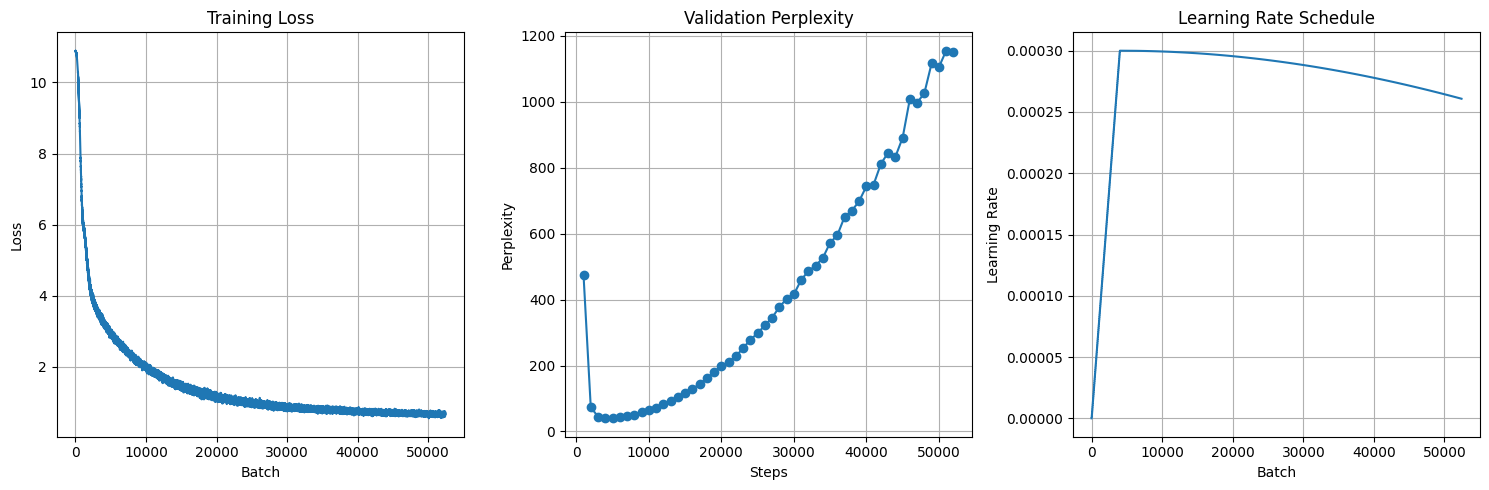

In [5]:
# -----------------------------------------------------------------------------
# Train the Reservoir Model
# -----------------------------------------------------------------------------

# Train the model
training_history = train_optimized_reservoir_model(
    optimized_model, 
    train_loader, 
    val_loader, 
    optimized_reservoir_config,
    tokenizer,
    SHARED_CONFIG
)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_history['train_losses'])
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(training_history['steps'], training_history['val_perplexities'], marker='o')
plt.title('Validation Perplexity')
plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(training_history['learning_rates'])
plt.title('Learning Rate Schedule')
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the model
torch.save(optimized_model.state_dict(), optimized_reservoir_config['SAVE_PATH'])

In [6]:
# # -----------------------------------------------------------------------------
# # Transformer Model Definition
# # -----------------------------------------------------------------------------

# class TinyLM(nn.Module):
#     """
#     A small language model based on the Transformer architecture.
#     """
#     def __init__(self, vocab_size: int = 50257, emb_dim: int = 768, block_size: int = 256, n_att_heads: int = 12,
#                  n_decoders: int = 12, device: str = 'cuda'):
#         super().__init__()
#         self.device = device
#         self.block_size = block_size
#         self.token_emb = nn.Embedding(vocab_size, emb_dim)
#         self.pos_emb = nn.Embedding(block_size, emb_dim)
#         self.decoders = nn.Sequential(*(TransformerDecoder(emb_dim, block_size, n_att_heads)
#                                         for _ in range(n_decoders)))
#         self.final_linear = nn.Linear(emb_dim, vocab_size)
#         self.layer_norm = nn.LayerNorm(emb_dim)

#     def generate(self, context: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
#         for _ in range(max_new_tokens):
#             context = context[:, -self.block_size:]
#             logits = self(context)[:, -1, :]
#             probabilities = nn.functional.softmax(logits, dim=-1)
#             next_token = torch.multinomial(probabilities, num_samples=1)
#             context = torch.cat([context, next_token], dim=1)
#         return context

#     def forward(self, x):
#         token_emb = self.token_emb(x)
#         pos_emb = self.pos_emb(torch.arange(min(self.block_size, x.size(1)), device=self.device))
#         x = token_emb + pos_emb
#         x = self.decoders(x)
#         x = self.layer_norm(x)
#         logits = self.final_linear(x)
#         return logits

# class TransformerDecoder(nn.Module):
#     """
#     A single Transformer decoder block.
#     """
#     def __init__(self, emb_dim: int = 768, block_size: int = 256, n_heads: int = 12, dropout: float = 0.2):
#         super().__init__()
#         self.emb_dim = emb_dim
#         self.n_heads = n_heads
#         self.head_projection = nn.Linear(emb_dim, 3 * emb_dim, bias=False)
#         self.register_buffer('tril', ~torch.tril(torch.ones(block_size, block_size)).type(torch.bool))
#         self.self_attention = nn.MultiheadAttention(emb_dim, n_heads, batch_first=True, dropout=0.2)
#         self.feed_fwd = nn.Sequential(
#             nn.Linear(emb_dim, emb_dim * 4),
#             nn.LeakyReLU(),
#             nn.Linear(emb_dim * 4, emb_dim),
#             nn.Dropout(dropout)
#         )
#         self.ln_1 = nn.LayerNorm(emb_dim)
#         self.ln_2 = nn.LayerNorm(emb_dim)

#     def forward(self, x):
#         x = self.ln_1(x)
#         x_proj = self.head_projection(x)
#         q, k, v = x_proj.split(self.emb_dim, dim=-1)
#         x = x + self.self_attention(q, k, v, attn_mask=self.tril[:x.size(1), :x.size(1)], need_weights=False)[0]
#         x = x + self.feed_fwd(self.ln_2(x))
#         return x

# @torch.no_grad()
# def eval_transformer_model(training_model: torch.nn.Module, val_loader: torch.utils.data.DataLoader, config: dict):
#     training_model.eval()
#     losses = []
#     criterion = nn.CrossEntropyLoss()
#     for k, (s_val, t_val) in enumerate(val_loader):
#         if k >= config['EVAL_ITER']:
#             break
#         s_val, t_val = s_val.to(config['DEVICE']), t_val.to(config['DEVICE'])
#         val_logits = training_model(s_val)
#         B, T, C = val_logits.shape
#         val_loss = criterion(val_logits.view(B * T, C), t_val.view(B * T))
#         losses.append(val_loss.item())
#     training_model.train()
#     return np.mean(losses)

# @torch.no_grad()
# def generate_from_transformer(training_model: TinyLM, config: dict, prompt="Once upon a time") -> str:
#     training_model.eval()
#     if prompt:
#         context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=config['DEVICE']).unsqueeze(0)
#     else:
#         context = torch.zeros((1, 1), dtype=torch.long, device=config['DEVICE'])
#     out_tokens = training_model.generate(context, max_new_tokens=config['MAX_OUT_TOKENS'])
#     training_model.train()
#     return tokenizer.decode(out_tokens[0].tolist())

# # Define Transformer model specific configuration
# transformer_config = {
#     # Model architecture
#     'EMB_SIZE': 512,
#     'N_ATTENTION_HEADS': 4,
#     'N_DECODER_BLOCKS': 2,
#     'VOCAB_SIZE': tokenizer.vocab_size,
    
#     # Training params from shared config
#     'MAX_OUT_TOKENS': SHARED_CONFIG['MAX_OUT_TOKENS'],
#     'EVAL_INTERVAL': SHARED_CONFIG['EVAL_INTERVAL'],
#     'EVAL_ITER': SHARED_CONFIG['EVAL_ITER'],
#     'LR': 3e-4,
#     'BATCH_SIZE': SHARED_CONFIG['BATCH_SIZE'],
#     'BLOCK_SIZE': SHARED_CONFIG['BLOCK_SIZE'],
#     'DEVICE': SHARED_CONFIG['DEVICE'],
#     'SAVE_PATH': SHARED_CONFIG['TRANSFORMER_SAVE_PATH'],
# }
# assert transformer_config['EMB_SIZE'] % transformer_config['N_ATTENTION_HEADS'] == 0, "Embedding size must be divisible by number of attention heads"

# # Initialize the model
# transformer_model = TinyLM(
#     emb_dim=transformer_config['EMB_SIZE'],
#     block_size=transformer_config['BLOCK_SIZE'],
#     n_att_heads=transformer_config['N_ATTENTION_HEADS'],
#     n_decoders=transformer_config['N_DECODER_BLOCKS'],
#     vocab_size=transformer_config['VOCAB_SIZE'],
#     device=transformer_config['DEVICE']
# ).to(transformer_config['DEVICE'])

# print(f"Transformer Model initialized on {SHARED_CONFIG['DEVICE']} with {sum(p.numel() for p in transformer_model.parameters() if p.requires_grad):,} trainable parameters.")

In [7]:
# -----------------------------------------------------------------------------
# Train the Transformer Model
# -----------------------------------------------------------------------------

# optimizer = torch.optim.Adam(transformer_model.parameters(), lr=transformer_config['LR'])
# criterion = nn.CrossEntropyLoss()

# # Lists to store metrics for plotting
# transformer_train_losses = []
# transformer_val_perplexities = []
# transformer_steps = []
# total_batches = 0

# print("Starting Transformer Model training...")
# for epoch in range(1, SHARED_CONFIG['EPOCHS'] + 1):
#     print(f"--- Epoch {epoch}/{SHARED_CONFIG['EPOCHS']} ---")
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
#     for batch in pbar:
#         sources, targets = batch
#         total_batches += 1
        
#         sources, targets = sources.to(SHARED_CONFIG['DEVICE']), targets.to(SHARED_CONFIG['DEVICE'])
#         logits = transformer_model(sources)
        
#         B, T, C = logits.shape
#         loss = criterion(logits.view(B * T, C), targets.view(B * T))
        
#         transformer_train_losses.append(loss.item())
#         pbar.set_postfix(loss=f"{loss.item():.4f}")

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if total_batches > 0 and total_batches % SHARED_CONFIG['EVAL_INTERVAL'] == 0:
#             val_loss = eval_transformer_model(transformer_model, val_loader, transformer_config)
#             perplexity = np.exp(val_loss)
#             transformer_val_perplexities.append(perplexity)
#             transformer_steps.append(total_batches)
#             print("\n" + "-" * 50)
#             print(f"Validation Loss: {val_loss:.4f}, Validation Perplexity: {perplexity:.4f}")
#             generated_text = generate_from_transformer(
#                 transformer_model, 
#                 transformer_config, 
#                 prompt="Once upon a time"
#             )
#             print("--- Sample Generation ---")
#             print(generated_text)
#             print("-" * 50)

# print("Transformer Model training finished.")

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(transformer_train_losses)
# plt.title('Transformer Model - Training Loss')
# plt.xlabel('Batch')
# plt.ylabel('Loss')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(transformer_steps, transformer_val_perplexities, marker='o')
# plt.title('Transformer Model - Validation Perplexity')
# plt.xlabel('Total Batches')
# plt.ylabel('Perplexity')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f"Saving Transformer model to {transformer_config['SAVE_PATH']}...")
# torch.save({
#     'model_state_dict': transformer_model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'config': transformer_config,
# }, transformer_config['SAVE_PATH'])
# print("Transformer Model saved.")

In [8]:
# -----------------------------------------------------------------------------
# Compare Model Performance
# -----------------------------------------------------------------------------

# # Visualize the validation perplexity of both models on the same plot
# plt.figure(figsize=(10, 6))
# plt.plot(steps, val_perplexities, marker='o', label='Reservoir Model')
# plt.plot(transformer_steps, transformer_val_perplexities, marker='s', label='Transformer Model')
# plt.title('Model Comparison - Validation Perplexity')
# plt.xlabel('Training Steps')
# plt.ylabel('Perplexity (lower is better)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, marker='o', label='Reservoir Model')
# plt.plot(transformer_train_losses, marker='s', label='Transformer Model')
# plt.title('Model Comparison - Train Loss')
# plt.xlabel('Batch')
# plt.ylabel('Loss (lower is better)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Generate some comparison text with the same prompt
print("=" * 80)
print("Model Comparison - Text Generation")
print("=" * 80)

prompt = "Once upon a time, there was a little"
print(f"Prompt: '{prompt}'\n")

# Generate from Reservoir model
reservoir_text = generate_from_reservoir(
    optimized_model, 
    prompt, 
    SHARED_CONFIG['MAX_OUT_TOKENS'], 
    optimized_reservoir_config,
    tokenizer
)
print("Reservoir Model Output:")
print("-" * 50)
print(reservoir_text)
print("\n")

# # Generate from Transformer model
# transformer_text = generate_from_transformer(
#     transformer_model, 
#     transformer_config, 
#     prompt=prompt
# )
# print("Transformer Model Output:")
# print("-" * 50)
# print(transformer_text)

# # Compare model size
# reservoir_params = sum(p.numel() for p in reservoir_model.parameters() if p.requires_grad)
# transformer_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

# print("\n" + "=" * 80)
# print(f"Reservoir Model: {reservoir_params:,} parameters")
# print(f"Transformer Model: {transformer_params:,} parameters")
# print(f"Size difference: {abs(reservoir_params - transformer_params):,} parameters")
# print(f"The {'Reservoir' if reservoir_params < transformer_params else 'Transformer'} model is smaller by {abs(100 - (100 * min(reservoir_params, transformer_params) / max(reservoir_params, transformer_params))):.1f}%")
# print("=" * 80)

Model Comparison - Text Generation
Prompt: 'Once upon a time, there was a little'

Reservoir Model Output:
--------------------------------------------------
Once upon a time, there was a little girl called Claire. Mary was very obedient, which was so she decided to do what would play with it. 

Mum smiled and told Jack listened to her mom for him. She was very special because she hugged her a bit sad. She wanted to make her feel better. She said, "Oh, I did you need. I will give you paint myuddles."
His mommy was very nice at her way.

"Can I want to catch it," Max


